In [53]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
import re
import pickle
from timeit import default_timer as timer
import sklearn
from sklearn.preprocessing import scale
from sklearn.manifold import Isomap, TSNE
from sklearn.metrics import silhouette_samples, silhouette_score
import scipy
import scipy.cluster.hierarchy
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import umap
import seaborn as sns
import matplotlib.cm as cm
import random

from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import mannwhitneyu

# from pysankey import sankey

from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN, SpectralClustering, Birch
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_selection import mutual_info_classif
from sklearn import metrics
import igraph
from math import ceil
from timeit import default_timer as timer
import subprocess
from pathlib import Path
from numpy import linalg as LA

import neuro_morpho_toolbox as nmt
from neuro_morpho_toolbox.ml_utilities import *
from neuro_morpho_toolbox.plot import qualitative_scatter, cell_in_map

import SimpleITK as sitk

from ipywidgets import interactive
import ipywidgets as widgets

import plotly.plotly as py
import plotly.offline as po
import plotly.graph_objs as go

po.init_notebook_mode(connected=True)

import colorlover as cl
from IPython.display import HTML

bs_child_to_parent = {}

for pid in nmt.bs.selected_regions:
    pname = nmt.bs.level.loc[pid, "Abbrevation"]
    cname = [nmt.bs.level.loc[i, "Abbrevation"] for i in nmt.bs.get_all_child_id(pid)]
    for i in cname:
        bs_child_to_parent[i] = pname
bs_child_to_parent["unknown"] = "unknown"

## Load data

In [54]:
# [metadata] = pickle.load(open("metadata_cluster.pickle", 'rb'))
[metadata] = pickle.load(open("metadata_cluster_cocluster.pickle", 'rb'))
metadata = metadata[~metadata.Celltype.isin(["CPU", "Others"])]
metadata = metadata[~metadata.cluster.isin(["NA"])]
all_cells = metadata.index.tolist()
metadata['Brain_id'] = ['Brain_'+i.split("_")[0] for i in all_cells]
metadata['SWC'] = ['../Data/swc/mapped/Data_for_analysis/swc/Whole/'+i+'.swc' for i in all_cells]
# metadata['Celltype'] = 'UnAssigned'
# metadata['Subtype'] = 'UnAssigned'

metadata.Celltype.value_counts()

LGd    31
VPM    30
VPL    19
MG     17
Name: Celltype, dtype: int64

In [55]:
df = pd.read_excel("../Subjective_celltype/tracking_table_QW_hz_LjL_px_09162019.284_cells.xlsx", index_col=[0])
region_list = pd.read_excel("../Subjective_celltype/tracking_table_QW_hz_LjL_px_09162019.284_cells.xlsx", sheet_name=1, header=None)[2].tolist()

# metadata = ns.features['soma_features'].region.copy()
metadata['Celltype'] = df.loc[metadata.index, "Confirmed"]
# # metadata['Celltype_note'] = df.loc[metadata.index, "Lijuan Note"]
# # metadata.loc[metadata["Celltype_note"]=="CPU", "Celltype"] = "CPU"
metadata.fillna("Others", inplace=True)
metadata.loc[metadata.Celltype.isin(["TH", "VPM/VPL"]), "Celltype"] = "TH_Uncertain"
metadata.loc[~metadata.Celltype.isin(["Others", "TH_Uncertain"]+region_list), "Celltype"] = "Others"
print(metadata.Celltype.value_counts())
# metadata
# pickle.dump([metadata], open("metadata.pickle", "wb"))

LGd    31
VPM    30
VPL    19
MG     17
Name: Celltype, dtype: int64


In [56]:
# celltype_color_dict = nmt.get_group_colors(metadata, "Celltype")
[celltype_color_dict] = pickle.load(open("colors.pickle", "rb"))
cluster_color_dict = nmt.get_group_colors(metadata, 'cluster')
brain_color_dict = nmt.get_group_colors(metadata, 'Brain_id')

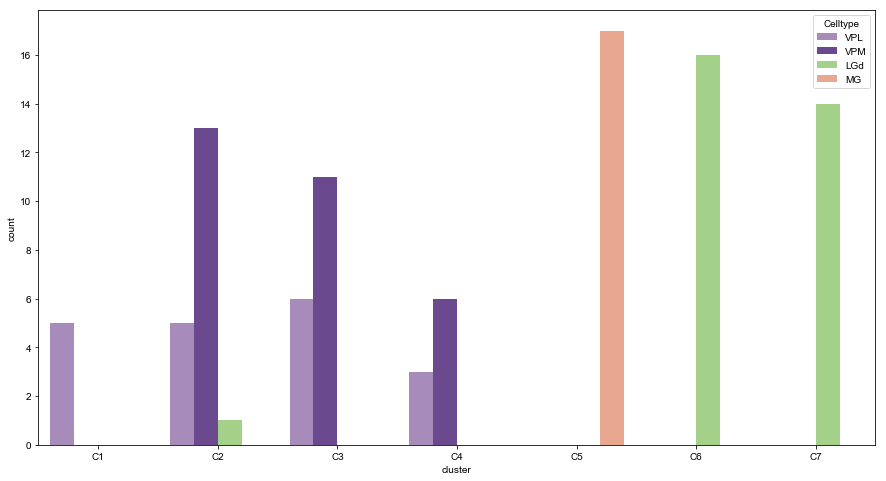

In [57]:
fig, ax = plt.subplots(1,1, figsize=(15,8))
sns.countplot(x="cluster", 
              data=metadata, 
              hue="Celltype", 
              palette=celltype_color_dict,
              ax=ax
             )

In [58]:
[soma] = pickle.load(open("features_soma.pickle", "rb"))
[projection] = pickle.load(open("features_projection.pickle", "rb"))
[lm_axon] = pickle.load(open("features_lm_axon.pickle", "rb"))
[lm_dendrite] = pickle.load(open("features_lm_dendrite.pickle", "rb"))

In [59]:
projection_df = projection.scaled_data.copy() - np.log(100)
projection_df = projection_df.loc[all_cells]
projection_df = projection_df.round(2)
projection_df.drop(columns=['ipsi_fiber tracts', 'contra_fiber tracts'], inplace=True)
use_features = projection_df.columns[np.sum(projection_df>0)>=3]
projection_df = projection_df[use_features]
print("Projection features: %d" % (projection_df.shape[1]))

Projection features: 41


In [60]:
soma_df = soma.raw_data.copy().loc[all_cells]

In [61]:
lm_axon_df = lm_axon.raw_data.copy().loc[all_cells]
use_cols = ['A_Overall_Width', 
            'A_Overall_Height', 
            'A_Overall_Depth', 
            'A_Total_Length', 
            'A_Max_Euclidean_Distance', 
            'A_Max_Path_Distance', 
            'A_Number_of_Branches', 
#             'Max Branch Order',
#             'Average Contraction', 
#             'Average Fragmentation',
#             'Average Bifurcation Angle Local', 
#             'Average Bifurcation Angle Remote', 
#             'Hausdorff Dimension',
            'AL_Total_Length',
            'AL_Number_of_Branches'
           ]
lm_axon_df = lm_axon_df[use_cols]
lm_axon_df_scale = pd.DataFrame(scale(lm_axon_df), 
                                index=lm_axon_df.index, 
                                columns=lm_axon_df.columns)


In [62]:
lm_dendrite_df = lm_dendrite.raw_data.copy().loc[all_cells]
use_cols = [
    'D_Number_of_Stems', 
    'D_Overall_Width', 
    'D_Overall_Height', 
    'D_Overall_Depth', 
    'D_Total_Length',
    'D_Max_Euclidean_Distance', 
    'D_Max_Path_Distance', 
    'D_Number_of_Branches', 
#     'D_Max_Branch_Order', # Add back after dendrite correction
]
lm_dendrite_df = lm_dendrite_df[use_cols]
lm_dendrite_df["D_Depth_Width-Ratio"] = lm_dendrite_df["D_Overall_Depth"] / lm_dendrite_df["D_Overall_Width"]
lm_dendrite_df_scale = pd.DataFrame(scale(lm_dendrite_df), 
                                    index=lm_dendrite_df.index, 
                                    columns=lm_dendrite_df.columns
                                   )


## Diff feature table

In [63]:
# u_clusters = sorted(list(set(metadata.cluster.tolist())))
# feature_df = projection_df
# feature_list = sorted(feature_df.columns.tolist())
# diff_df = pd.DataFrame(columns=["P-value"]+u_clusters)
# for cur_feature in feature_list:
#     anova_input = []
#     cluster_value = []
#     for i, cur_cluster in enumerate(u_clusters):
#         cur_df = feature_df.loc[metadata.cluster==cur_cluster, cur_feature]
#         anova_input.append(cur_df.tolist())
#         cluster_value.append(np.median(cur_df))
#     _, pv = scipy.stats.kruskal(*anova_input)
#     if pv<0.01:
#         tp = [pv] + cluster_value
#         diff_df.loc[cur_feature] = tp
# diff_df.round(2)
# diff_df.sort_values("P-value")

In [65]:
def get_diff_df(feature_df, metadata, group_by="cluster", sel_groups=None, pv_thres=0.01, mean_thres=0):    
    all_groups = sorted(list(set(metadata[group_by].tolist())))
    if sel_groups is None:
        u_groups = all_groups
    else:
        assert all([(i in all_groups) for i in sel_groups]), "Invalid values in sel_groups"
        u_groups = sel_groups
    feature_list = sorted(feature_df.columns.tolist())
    diff_df = pd.DataFrame(columns=["P-value"]+u_groups)
    for cur_feature in feature_list:
        anova_input = []
        anova_input_var = []
        group_value = []
        for i, cur_group in enumerate(u_groups):
            cur_df = feature_df.loc[metadata[group_by]==cur_group, cur_feature]
            anova_input.append(cur_df.tolist())
            anova_input_var.append(np.var(cur_df.tolist()))
            group_value.append(np.mean(cur_df))
        if all([(i<1e-10) for i in anova_input_var]):
            continue  # Skip testing if all values are zeros
        _, pv = scipy.stats.kruskal(*anova_input)
        if ((pv<pv_thres) & (np.max(group_value)>mean_thres)):
            tp = [pv] + group_value
            diff_df.loc[cur_feature] = tp
    diff_df = diff_df.round(2)
    diff_df.sort_values("P-value")
    return diff_df

lgd_clusters = ['C6', 'C7']
vp_clusters = ['C1', 'C2', 'C3', 'C4']

cur_clusters = lgd_clusters
diff_soma = get_diff_df(soma_df, metadata, sel_groups=cur_clusters)
diff_projection = get_diff_df(projection_df, metadata, sel_groups=cur_clusters, mean_thres=3)
diff_axon = get_diff_df(lm_axon_df, metadata, sel_groups=cur_clusters)
diff_dendrite = get_diff_df(lm_dendrite_df, metadata, sel_groups=cur_clusters)
lgd_diff_table = pd.concat([diff_soma, diff_projection, diff_axon, diff_dendrite], axis=0)

cur_clusters = vp_clusters
diff_soma = get_diff_df(soma_df, metadata, sel_groups=cur_clusters)
diff_projection = get_diff_df(projection_df, metadata, sel_groups=cur_clusters, mean_thres=3)
diff_axon = get_diff_df(lm_axon_df, metadata, sel_groups=cur_clusters)
diff_dendrite = get_diff_df(lm_dendrite_df, metadata, sel_groups=cur_clusters)
vp_diff_table = pd.concat([diff_soma, diff_projection, diff_axon, diff_dendrite], axis=0)


In [66]:
vp_diff_table

,P-value,C1,C2,C3,C4
x,0.00,7028.85,7112.81,6761.14,6836.54
y,0.00,3690.71,3341.60,3532.10,4178.48
z,0.00,2708.50,3062.69,3288.19,3612.77
ipsi_AUDd,0.00,4.11,1.06,0.00,0.00
ipsi_CP,0.01,4.14,3.71,4.31,4.01
ipsi_SSp-bfd,0.00,3.31,6.23,3.75,0.36
ipsi_SSp-ll,0.00,5.31,0.00,0.00,0.20
ipsi_SSp-m,0.00,0.00,0.00,1.30,5.27
ipsi_SSp-n,0.00,0.00,0.00,4.90,2.00
ipsi_SSp-tr,0.00,5.09,0.18,0.00,0.00


In [67]:
lgd_diff_table

,P-value,C6,C7
ipsi_VISp,0.00,5.93,6.49
AL_Total_Length,0.00,293.02,431.08
A_Max_Path_Distance,0.01,9987.76,14441.75
A_Overall_Height,0.01,3103.13,2652.94
A_Total_Length,0.00,33641.65,83200.75
D_Max_Path_Distance,0.00,220.68,523.88
D_Number_of_Branches,0.00,106.31,125.57
D_Total_Length,0.00,4843.95,14460.77


In [71]:
lm_axon_df.loc[metadata.cluster=='C7']

ID,A_Overall_Width,A_Overall_Height,A_Overall_Depth,A_Total_Length,A_Max_Euclidean_Distance,A_Max_Path_Distance,A_Number_of_Branches,AL_Total_Length,AL_Number_of_Branches
17302_00065,3140.95,2124.35,2523.73,34449.4,3012.53,10751.20,370.0,293.496,1.0
17302_00066,3026.05,2335.40,1787.18,35989.7,2934.78,8191.90,354.0,353.698,3.0
17302_00117,3036.12,3104.18,2438.88,67342.9,3734.25,9868.72,635.0,256.390,1.0
18458_00242,3227.62,3105.52,2254.80,54550.1,3773.04,10724.30,472.0,221.897,1.0
17302_00049,3111.68,2536.95,1612.82,34455.1,2998.93,7888.14,321.0,310.706,1.0
17545_00173,2578.05,2822.80,1452.27,102058.0,2727.80,18514.20,278.0,511.288,1.0
17545_00095,3043.05,2392.43,2304.88,119002.0,2850.81,19377.00,497.0,408.642,1.0
17545_00093,3223.47,3182.50,2139.33,50012.2,2993.25,18287.80,119.0,347.118,1.0
17545_00170,2942.68,2339.12,1785.38,182372.0,2838.63,17344.00,479.0,526.888,1.0
17545_00091,2458.45,2411.85,1483.82,115283.0,2513.50,13702.70,362.0,484.975,1.0


In [ ]:
# u_clusters = sorted(list(set(metadata.cluster.tolist())))
# u_clusters = ["C1", "C3", "C4"]
# feature_df = projection_df
# feature_list = sorted(feature_df.columns.tolist())
# diff_df = pd.DataFrame(columns=["P-value"]+u_clusters)
# for cur_feature in ['ipsi_ECT']:
#     anova_input = []
#     cluster_value = []
#     for i, cur_cluster in enumerate(u_clusters):
#         cur_df = feature_df.loc[metadata.cluster==cur_cluster, cur_feature]
#         anova_input.append(cur_df.tolist())
#         cluster_value.append(np.median(cur_df))
#     _, pv = scipy.stats.kruskal(*anova_input)
#     if pv<0.01:
#         tp = [pv] + cluster_value
#         diff_df.loc[cur_feature] = tp
# diff_df = diff_df.round(2)
# diff_df.sort_values("P-value")